# TalkingData Kaggle competition

**Contest URL**: https://www.kaggle.com/c/talkingdata-mobile-user-demographics

**Background**: (taken from the above link):
Nothing is more comforting than being greeted by your favorite drink just as you walk through the door of the corner café. While a thoughtful barista knows you take a macchiato every Wednesday morning at 8:15, it’s much more difficult in a digital space for your preferred brands to personalize your experience.

TalkingData, China’s largest third-party mobile data platform, understands that everyday choices and behaviors paint a picture of who we are and what we value. Currently, TalkingData is seeking to leverage behavioral data from more than 70% of the 500 million mobile devices active daily in China to help its clients better understand and interact with their audiences.

In this competition, Kagglers are challenged to build a model predicting users’ demographic characteristics based on their app usage, geolocation, and mobile device properties. Doing so will help millions of developers and brand advertisers around the world pursue data-driven marketing efforts which are relevant to their users and catered to their preferences.

**Lots of code from the following Kaggle kernels is adapted and or applied verbatim:**
- https://www.kaggle.com/xiaoml/talkingdata-mobile-user-demographics/bag-of-app-id-python-2-27392/code
- https://www.kaggle.com/dvasyukova/talkingdata-mobile-user-demographics/a-linear-model-on-apps-and-labels
- https://www.kaggle.com/alexxanderlarko/talkingdata-mobile-user-demographics/bag-of-apps-keras-11-08-16

**Iteration on model parameters is tracked here:**
- https://docs.google.com/spreadsheets/d/1nA9Tmq4fGEN0941bnhjD_FHIily4ndXO89RrzGoBvLU/edit?usp=sharing

**My Kaggle profile:**
- https://www.kaggle.com/bgnipp

## Imports and data loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
now = datetime.datetime.now()
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss

%matplotlib inline


print "Loading data..."
try:
    gatrain = pd.read_csv('input/gender_age_train.csv',
                      index_col='device_id')
    gatest = pd.read_csv('input/gender_age_test.csv',
                     index_col = 'device_id')
    phone = pd.read_csv('input/phone_brand_device_model.csv')
    # Get rid of duplicate device ids in phone
    phone = phone.drop_duplicates('device_id',keep='first').set_index('device_id')
    
    events = pd.read_csv('input/events.csv',
                     parse_dates=['timestamp'], index_col='event_id')
    appevents = pd.read_csv('input/app_events.csv', 
                        usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
    applabels = pd.read_csv('input/app_labels.csv')
    print "Load succeeded!"
except:
    "Data load failed :("

Loading data...
Load succeeded!


## Exploration

Data schema (from Kaggle, with annotations I added)

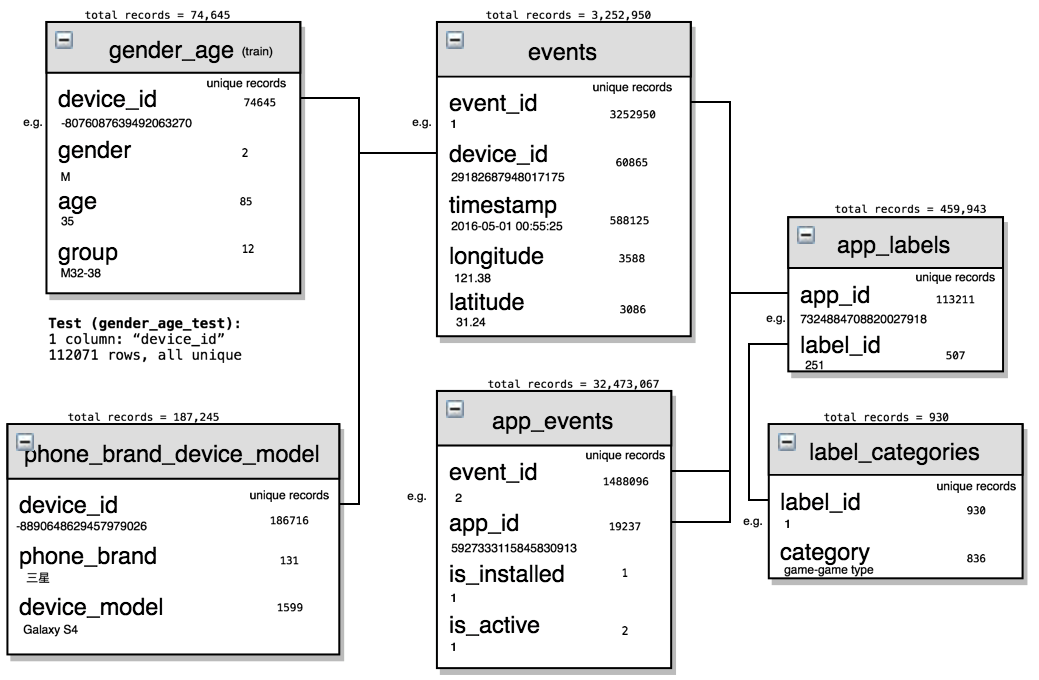

In [2]:
from IPython.display import Image
Image(filename='schema.png') 

**Data file heads**

In [3]:
gatrain.head(3)

,gender,age,group
device_id,,,
-8076087639492063270,M,35,M32-38
-2897161552818060146,M,35,M32-38
-8260683887967679142,M,35,M32-38


In [5]:
gatest.head(3)

""
device_id
1002079943728939269
-1547860181818787117
7374582448058474277


In [6]:
events.head(3)

,device_id,timestamp,longitude,latitude
event_id,,,,
1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70


In [7]:
applabels.head(3)

,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406


In [8]:
phone.head(3)

,phone_brand,device_model
device_id,,
-8890648629457979026,小米,红米
1277779817574759137,小米,MI 2
5137427614288105724,三星,Galaxy S4


In [9]:
appevents.head(3)

,event_id,app_id,is_active
0,2,5927333115845830913,True
1,2,-5720078949152207372,False
2,2,-1633887856876571208,False


In [10]:
applabels.head(3)

,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406


**Age/gender distribution (training set)**

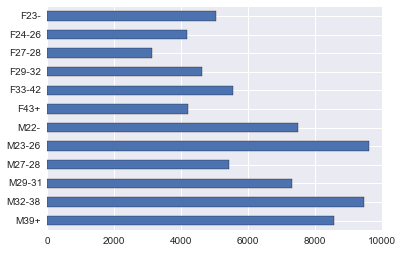

In [11]:
gatrain.group.value_counts().sort_index(ascending=False).plot(kind='barh')

**Observations**

- Most of the devices (in both training and test sets) have no events, so we must rely on phone brand/model for these
- All is_active values in the app_events data/table are the same, so we can disregard it
- The timestamps span a period of about a week.  Times are in UTC.
- Many latitude/longitude values are 0.0 (missing)
- The label_categories data/table simply provides a string identifier for each (numerically identified) label_id, so this is not useful for processing
- Refer to the feature engineering section below for further exploration/analysis



## Pre-processing
One hot encoding (in sparse matrix) for phone brand, device model, installed apps, and app labels

**Phone brand**

In [12]:
#create enumeration column (to mark which train/test set row device id's belong to) 
gatrain['trainrow'] = np.arange(gatrain.shape[0])
gatest['testrow'] = np.arange(gatest.shape[0])

In [13]:
#encode phone.brand values
brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])

#join phone.brand values on the train and test sets
gatrain['brand'] = phone['brand']
gatest['brand'] = phone['brand']

#one-hot sparse encoding of phone.brand values corresponding to test and train sets
Xtr_brand = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.brand)))
Xte_brand = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.brand)))
print('Brand features: train shape {}, test shape {}'.format(Xtr_brand.shape, Xte_brand.shape))

Brand features: train shape (74645, 131), test shape (112071, 131)


**Device model**

In [14]:
#concatenate phone.device_id and phone.phone_brand, and encode the results
m = phone.phone_brand.str.cat(phone.device_model)
modelencoder = LabelEncoder().fit(m)

#join the results on phone, test, and train dataframes
phone['model'] = modelencoder.transform(m)
gatrain['model'] = phone['model']
gatest['model'] = phone['model']

#one-hot sparse encoding of phone.model values corresponding to test and train sets
Xtr_model = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.model)))
Xte_model = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.model)))

print('Model features: train shape {}, test shape {}'.format(Xtr_model.shape, Xte_model.shape))

Model features: train shape (74645, 1667), test shape (112071, 1667)


**Installed apps**

In [15]:
#encode app_ids (in app_events table)
appencoder = LabelEncoder().fit(appevents.app_id)
appevents['app'] = appencoder.transform(appevents.app_id)
napps = len(appencoder.classes_)

#merge appevents table with corresponding device id's 
deviceapps = appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)

#group by device_id and app, and count the number of events corresponding to each app 
deviceapps = deviceapps.groupby(['device_id','app'])['app'].agg(['size'])

#for groups of device_id/app, merge with 'trainrow' and 'testrow' value
deviceapps = deviceapps.merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
deviceapps = deviceapps.merge(gatest[['testrow']], how='left', left_index=True, right_index=True)

deviceapps = deviceapps.reset_index()
deviceapps.head()

,device_id,app,size,trainrow,testrow
0,-9222956879900151005,548,18,21594,NaN
1,-9222956879900151005,1096,18,21594,NaN
2,-9222956879900151005,1248,26,21594,NaN
3,-9222956879900151005,1545,12,21594,NaN
4,-9222956879900151005,1664,18,21594,NaN


In [16]:
#create subset of deviceapps for all rows w/ non NaN trainrow values
d = deviceapps.dropna(subset=['trainrow'])
#one-hot sparse encoding of app values corresponding trainrows
Xtr_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)), 
                      shape=(gatrain.shape[0],napps))
#non-one-hot spare encoding (number of occurances of app event, instead of app present true/false)
Xtr_app_sized = csr_matrix((d['size'], (d.trainrow, d.app)), 
                      shape=(gatrain.shape[0],napps))

#same as above, but for testrows 
d = deviceapps.dropna(subset=['testrow'])
Xte_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)), 
                      shape=(gatest.shape[0],napps))
Xte_app_sized = csr_matrix((d['size'], (d.testrow, d.app)), 
                      shape=(gatest.shape[0],napps))

print('Apps data: train shape {}, test shape {}'.format(Xtr_app.shape, Xte_app.shape))

Apps data: train shape (74645, 19237), test shape (112071, 19237)


**App labels**

In [17]:
#drop all irrelevant rows from applabels (labels not related to appevents via app_id)
applabels = applabels.loc[applabels.app_id.isin(appevents.app_id.unique())]

#encode app_id
applabels['app'] = appencoder.transform(applabels.app_id)

#encode label id 
labelencoder = LabelEncoder().fit(applabels.label_id)
applabels['label'] = labelencoder.transform(applabels.label_id)
nlabels = len(labelencoder.classes_)

In [18]:
#new df (columns = device_id, app, label), merging applabels and device apps
devicelabels = deviceapps[['device_id','app']].merge(applabels[['app','label']])

#group by device_id and label, and count the number of labels corresponding to each device 
devicelabels = devicelabels.groupby(['device_id','label'])['app'].agg(['size'])

#for groups of device_id/labels, merge with 'trainrow' and 'testrow' value
devicelabels = devicelabels.merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
devicelabels = devicelabels.merge(gatest[['testrow']], how='left', left_index=True, right_index=True)

devicelabels = devicelabels.reset_index()
devicelabels.head()

,device_id,label,size,trainrow,testrow
0,-9222956879900151005,117,1,21594,NaN
1,-9222956879900151005,120,1,21594,NaN
2,-9222956879900151005,126,1,21594,NaN
3,-9222956879900151005,138,2,21594,NaN
4,-9222956879900151005,147,2,21594,NaN


In [19]:
#create subset of devicelabels for all rows w/ non NaN trainrow values
d = devicelabels.dropna(subset=['trainrow'])
#one-hot sparse encoding of label values corresponding trainrows
Xtr_label = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)), 
                      shape=(gatrain.shape[0],nlabels))
#non-one-hot spare encoding (number of occurances of label event, instead of label present true/false)
Xtr_label_sized = csr_matrix((d['size'], (d.trainrow, d.label)), 
                      shape=(gatrain.shape[0],nlabels))

#same as above, but for testrows 
d = devicelabels.dropna(subset=['testrow'])
Xte_label = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)), 
                      shape=(gatest.shape[0],nlabels))
Xte_label_sized = csr_matrix((d['size'], (d.testrow, d.label)), 
                      shape=(gatest.shape[0],nlabels))

print('Labels data: train shape {}, test shape {}'.format(Xtr_label.shape, Xte_label.shape))

Labels data: train shape (74645, 492), test shape (112071, 492)


**Combine feature sparse matricies**

In [20]:
#with one-hot-encoded device and app attributes
Xtrain = hstack((Xtr_brand, Xtr_model, Xtr_app, Xtr_label), format='csr')
Xtest =  hstack((Xte_brand, Xte_model, Xte_app, Xte_label), format='csr')

#with non-one-hot-encoded device and app attribtues (includes # of occurances for each)
Xtrain_sized = hstack((Xtr_brand, Xtr_model, Xtr_app_sized, Xtr_label_sized), format='csr')
Xtest_sized =  hstack((Xte_brand, Xte_model, Xte_app_sized, Xte_label_sized), format='csr')

print('Xtrain/Xtest: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

Xtrain/Xtest: train shape (74645, 21527), test shape (112071, 21527)


**Cross validation split**

In [21]:
#encode group (e.g. "M32-38") as target array 
targetencoder = LabelEncoder().fit(gatrain.group)
targetencoder2 = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

LB score: 2.62504

# Neural nets

In [41]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import SGD

from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split

Using Theano backend.


In [42]:
#use sparse matricies w/ keras NN
#taken from kaggle user chenglong
#kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22567/neural-network-for-sparse-matrices

def batch_generator(X, y, batch_size, shuffle):
    number_of_batches = np.ceil(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:].toarray()
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

In [43]:
def batch_generatorp(X, batch_size, shuffle):
    number_of_batches = X.shape[0] / np.ceil(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    while True:
        batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]
        X_batch = X[batch_index, :].toarray()
        counter += 1
        yield X_batch
        if (counter == number_of_batches):
            counter = 0

In [44]:
def baseline_model():
    model = Sequential()
    model.add(Dense(50, input_dim=Xtrain.shape[1], init='normal', activation='tanh'))
    model.add(Dropout(0.6))
    model.add(Dense(12, init='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])  #logloss
    return model

In [45]:
#one-hot encode traing targets 
dummy_y = np_utils.to_categorical(y)
print "done"

done


**Train 1st NN**

In [50]:
#Initialize keras sequential model 
model=baseline_model()

#test train split
X_train, X_val, y_train, y_val = train_test_split(Xtrain, dummy_y, test_size=0.01, random_state=9)

fit= model.fit_generator(generator=batch_generator(X_train, y_train, 32, True),
                         nb_epoch=15,
                         samples_per_epoch=69984,
                         validation_data=(X_val.todense(), y_val), verbose=2
                         )

Epoch 1/15
35s - loss: 2.4072 - acc: 0.1457 - val_loss: 2.3508 - val_acc: 0.1821
Epoch 2/15
58s - loss: 2.3405 - acc: 0.1696 - val_loss: 2.3123 - val_acc: 0.1888
Epoch 3/15
71s - loss: 2.3193 - acc: 0.1772 - val_loss: 2.2966 - val_acc: 0.1874
Epoch 4/15
77s - loss: 2.3045 - acc: 0.1822 - val_loss: 2.2881 - val_acc: 0.1888
Epoch 5/15
81s - loss: 2.2973 - acc: 0.1858 - val_loss: 2.2769 - val_acc: 0.1941
Epoch 6/15
84s - loss: 2.2926 - acc: 0.1888 - val_loss: 2.2715 - val_acc: 0.2142
Epoch 7/15
85s - loss: 2.2836 - acc: 0.1920 - val_loss: 2.2693 - val_acc: 0.2088
Epoch 8/15
86s - loss: 2.2779 - acc: 0.1950 - val_loss: 2.2652 - val_acc: 0.2021
Epoch 9/15
86s - loss: 2.2755 - acc: 0.1965 - val_loss: 2.2656 - val_acc: 0.1968
Epoch 10/15
86s - loss: 2.2733 - acc: 0.1979 - val_loss: 2.2668 - val_acc: 0.2008
Epoch 11/15
87s - loss: 2.2675 - acc: 0.1997 - val_loss: 2.2607 - val_acc: 0.2062
Epoch 12/15
87s - loss: 2.2643 - acc: 0.2005 - val_loss: 2.2594 - val_acc: 0.2021
Epoch 13/15
87s - loss: 2

Apply to test data

In [51]:
scores = model.predict_generator(generator=batch_generatorp(Xtest, 32, False), val_samples=Xtest.shape[0])
nn_pred_test_1_1 = pd.DataFrame(scores, index = gatest.index, columns=targetencoder.classes_)
name = 'output/nnet_1_1' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
nn_pred_test_1_1.to_csv(name,index=True)

**Train 1st NN, second iteration**

In [52]:
#Initialize keras sequential model 
model=baseline_model()

#test train split
X_train, X_val, y_train, y_val = train_test_split(Xtrain, dummy_y, test_size=0.01, random_state=4)

fit= model.fit_generator(generator=batch_generator(X_train, y_train, 32, True),
                         nb_epoch=15,
                         samples_per_epoch=69984,
                         validation_data=(X_val.todense(), y_val), verbose=2
                         )

Epoch 1/15
36s - loss: 2.4039 - acc: 0.1502 - val_loss: 2.3459 - val_acc: 0.1687
Epoch 2/15
59s - loss: 2.3419 - acc: 0.1682 - val_loss: 2.3107 - val_acc: 0.1660
Epoch 3/15
71s - loss: 2.3193 - acc: 0.1755 - val_loss: 2.2949 - val_acc: 0.1647
Epoch 4/15
82s - loss: 2.3060 - acc: 0.1836 - val_loss: 2.2858 - val_acc: 0.1727
Epoch 5/15
88s - loss: 2.2973 - acc: 0.1874 - val_loss: 2.2791 - val_acc: 0.1660
Epoch 6/15
84s - loss: 2.2896 - acc: 0.1921 - val_loss: 2.2729 - val_acc: 0.1901
Epoch 7/15
88s - loss: 2.2836 - acc: 0.1936 - val_loss: 2.2711 - val_acc: 0.1807
Epoch 8/15
86s - loss: 2.2784 - acc: 0.1962 - val_loss: 2.2701 - val_acc: 0.1941
Epoch 9/15
86s - loss: 2.2705 - acc: 0.1983 - val_loss: 2.2659 - val_acc: 0.1861
Epoch 10/15
88s - loss: 2.2699 - acc: 0.1994 - val_loss: 2.2630 - val_acc: 0.1888
Epoch 11/15
88s - loss: 2.2682 - acc: 0.1992 - val_loss: 2.2649 - val_acc: 0.1954
Epoch 12/15
88s - loss: 2.2661 - acc: 0.2014 - val_loss: 2.2606 - val_acc: 0.1981
Epoch 13/15
90s - loss: 2

Apply to test data

In [53]:
scores = model.predict_generator(generator=batch_generatorp(Xtest, 32, False), val_samples=Xtest.shape[0])
nn_pred_test_1_2 = pd.DataFrame(scores, index = gatest.index, columns=targetencoder.classes_)
name = 'output/nnet_1_2' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
nn_pred_test_1_2.to_csv(name,index=True)

**Train 1st NN, third iteration**

In [54]:
#Initialize keras sequential model 
model=baseline_model()

#test train split
X_train, X_val, y_train, y_val = train_test_split(Xtrain, dummy_y, test_size=0.01, random_state=22)

fit= model.fit_generator(generator=batch_generator(X_train, y_train, 32, True),
                         nb_epoch=15,
                         samples_per_epoch=69984,
                         validation_data=(X_val.todense(), y_val), verbose=2
                         )

Epoch 1/15
37s - loss: 2.4057 - acc: 0.1472 - val_loss: 2.3390 - val_acc: 0.1593
Epoch 2/15
59s - loss: 2.3425 - acc: 0.1682 - val_loss: 2.3067 - val_acc: 0.1566
Epoch 3/15
75s - loss: 2.3179 - acc: 0.1803 - val_loss: 2.2882 - val_acc: 0.1687
Epoch 4/15
82s - loss: 2.3051 - acc: 0.1831 - val_loss: 2.2782 - val_acc: 0.1754
Epoch 5/15
84s - loss: 2.2977 - acc: 0.1888 - val_loss: 2.2734 - val_acc: 0.1780
Epoch 6/15
86s - loss: 2.2884 - acc: 0.1896 - val_loss: 2.2668 - val_acc: 0.1834
Epoch 7/15
87s - loss: 2.2857 - acc: 0.1932 - val_loss: 2.2617 - val_acc: 0.1847
Epoch 8/15
88s - loss: 2.2803 - acc: 0.1934 - val_loss: 2.2595 - val_acc: 0.1981
Epoch 9/15
89s - loss: 2.2720 - acc: 0.1984 - val_loss: 2.2573 - val_acc: 0.1901
Epoch 10/15
87s - loss: 2.2703 - acc: 0.1976 - val_loss: 2.2563 - val_acc: 0.1888
Epoch 11/15
88s - loss: 2.2672 - acc: 0.2012 - val_loss: 2.2568 - val_acc: 0.1914
Epoch 12/15
88s - loss: 2.2647 - acc: 0.2013 - val_loss: 2.2531 - val_acc: 0.1888
Epoch 13/15
90s - loss: 2

Apply to test data

In [55]:
scores = model.predict_generator(generator=batch_generatorp(Xtest, 32, False), val_samples=Xtest.shape[0])
nn_pred_test_1_3 = pd.DataFrame(scores, index = gatest.index, columns=targetencoder.classes_)
name = 'output/nnet_1_3' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
nn_pred_test_1_3.to_csv(name,index=True)

LB score: 2.25468

**Train second NN, 1st iteration**

In [56]:

from keras.layers.advanced_activations import PReLU
def baseline_model():
    
    model = Sequential()
    model.add(Dense(150, input_dim=Xtrain.shape[1], init='normal'))
    model.add(PReLU())
    model.add(Dropout(0.4))
    model.add(Dense(50, input_dim=Xtrain.shape[1], init='normal'))
    model.add(PReLU())
    model.add(Dropout(0.2))
    model.add(Dense(12, init='normal', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])  #logloss
    
    return model

In [57]:
model=baseline_model()

X_train, X_val, y_train, y_val = train_test_split(Xtrain, dummy_y, test_size=0.01, random_state=52)

fit= model.fit_generator(generator=batch_generator(X_train, y_train, 32, True),
                         nb_epoch=15,
                         samples_per_epoch=69984,
                         validation_data=(X_val.todense(), y_val), verbose=2
                         )

Epoch 1/15
116s - loss: 2.3679 - acc: 0.1596 - val_loss: 2.3205 - val_acc: 0.1714
Epoch 2/15
183s - loss: 2.2982 - acc: 0.1834 - val_loss: 2.2986 - val_acc: 0.1834
Epoch 3/15
213s - loss: 2.2811 - acc: 0.1920 - val_loss: 2.2873 - val_acc: 0.1888
Epoch 4/15
219s - loss: 2.2621 - acc: 0.1972 - val_loss: 2.2901 - val_acc: 0.1914
Epoch 5/15
236s - loss: 2.2504 - acc: 0.2032 - val_loss: 2.2878 - val_acc: 0.2075
Epoch 6/15
231s - loss: 2.2412 - acc: 0.2093 - val_loss: 2.2953 - val_acc: 0.2035
Epoch 7/15
235s - loss: 2.2326 - acc: 0.2128 - val_loss: 2.2892 - val_acc: 0.2102
Epoch 8/15
241s - loss: 2.2239 - acc: 0.2168 - val_loss: 2.2971 - val_acc: 0.2062
Epoch 9/15
247s - loss: 2.2131 - acc: 0.2213 - val_loss: 2.2931 - val_acc: 0.2075
Epoch 10/15
231s - loss: 2.2056 - acc: 0.2237 - val_loss: 2.2896 - val_acc: 0.2182
Epoch 11/15
231s - loss: 2.1978 - acc: 0.2283 - val_loss: 2.2958 - val_acc: 0.2062
Epoch 12/15
234s - loss: 2.1964 - acc: 0.2280 - val_loss: 2.2978 - val_acc: 0.2088
Epoch 13/15
2

Apply to test data

In [58]:
scores = model.predict_generator(generator=batch_generatorp(Xtest, 32, False), val_samples=Xtest.shape[0])
nn_pred_test_2_1 = pd.DataFrame(scores, index = gatest.index, columns=targetencoder.classes_)
name = 'output/nnet_2_1' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
nn_pred_test_2_1.to_csv(name,index=True)

**Train second NN, 2nd iteration**

In [59]:
model=baseline_model()

X_train, X_val, y_train, y_val = train_test_split(Xtrain, dummy_y, test_size=0.01, random_state=92)

fit= model.fit_generator(generator=batch_generator(X_train, y_train, 32, True),
                         nb_epoch=15,
                         samples_per_epoch=69984,
                         validation_data=(X_val.todense(), y_val), verbose=2
                         )

Epoch 1/15
109s - loss: 2.3688 - acc: 0.1566 - val_loss: 2.2634 - val_acc: 0.2021
Epoch 2/15
179s - loss: 2.2989 - acc: 0.1857 - val_loss: 2.2334 - val_acc: 0.1968
Epoch 3/15
218s - loss: 2.2767 - acc: 0.1934 - val_loss: 2.2218 - val_acc: 0.1901
Epoch 4/15
225s - loss: 2.2625 - acc: 0.1982 - val_loss: 2.2125 - val_acc: 0.1968
Epoch 5/15
231s - loss: 2.2525 - acc: 0.2026 - val_loss: 2.2062 - val_acc: 0.2048
Epoch 6/15
223s - loss: 2.2392 - acc: 0.2090 - val_loss: 2.2011 - val_acc: 0.2062
Epoch 7/15
234s - loss: 2.2325 - acc: 0.2128 - val_loss: 2.2027 - val_acc: 0.2115
Epoch 8/15
238s - loss: 2.2262 - acc: 0.2152 - val_loss: 2.1970 - val_acc: 0.2169
Epoch 9/15
243s - loss: 2.2151 - acc: 0.2194 - val_loss: 2.2006 - val_acc: 0.2075
Epoch 10/15
235s - loss: 2.2086 - acc: 0.2205 - val_loss: 2.1987 - val_acc: 0.2195
Epoch 11/15
238s - loss: 2.2017 - acc: 0.2258 - val_loss: 2.2059 - val_acc: 0.2182
Epoch 12/15
231s - loss: 2.1915 - acc: 0.2313 - val_loss: 2.2106 - val_acc: 0.2169
Epoch 13/15
2

Apply to test data

In [60]:
scores = model.predict_generator(generator=batch_generatorp(Xtest, 32, False), val_samples=Xtest.shape[0])
nn_pred_test_2_2 = pd.DataFrame(scores, index = gatest.index, columns=targetencoder.classes_)
name = 'output/nnet_2_2' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
nn_pred_test_2_2.to_csv(name,index=True)

**Train second NN, 3rd iteration**

In [61]:
model=baseline_model()

X_train, X_val, y_train, y_val = train_test_split(Xtrain, dummy_y, test_size=0.01, random_state=95)

fit= model.fit_generator(generator=batch_generator(X_train, y_train, 32, True),
                         nb_epoch=15,
                         samples_per_epoch=69984,
                         validation_data=(X_val.todense(), y_val), verbose=2
                         )

Epoch 1/15
110s - loss: 2.3685 - acc: 0.1592 - val_loss: 2.3069 - val_acc: 0.1861
Epoch 2/15
188s - loss: 2.3012 - acc: 0.1818 - val_loss: 2.2916 - val_acc: 0.1981
Epoch 3/15
223s - loss: 2.2759 - acc: 0.1942 - val_loss: 2.2813 - val_acc: 0.2129
Epoch 4/15
234s - loss: 2.2644 - acc: 0.1973 - val_loss: 2.2814 - val_acc: 0.2088
Epoch 5/15
240s - loss: 2.2535 - acc: 0.2043 - val_loss: 2.2702 - val_acc: 0.2115
Epoch 6/15
246s - loss: 2.2415 - acc: 0.2084 - val_loss: 2.2680 - val_acc: 0.2276
Epoch 7/15
248s - loss: 2.2300 - acc: 0.2117 - val_loss: 2.2784 - val_acc: 0.2048
Epoch 8/15
250s - loss: 2.2279 - acc: 0.2145 - val_loss: 2.2753 - val_acc: 0.2102
Epoch 9/15
234s - loss: 2.2181 - acc: 0.2183 - val_loss: 2.2721 - val_acc: 0.2142
Epoch 10/15
245s - loss: 2.2096 - acc: 0.2230 - val_loss: 2.2791 - val_acc: 0.2088
Epoch 11/15
243s - loss: 2.1997 - acc: 0.2259 - val_loss: 2.2715 - val_acc: 0.2209
Epoch 12/15
239s - loss: 2.1969 - acc: 0.2274 - val_loss: 2.2783 - val_acc: 0.2222
Epoch 13/15
2

Apply to test data

In [62]:
scores = model.predict_generator(generator=batch_generatorp(Xtest, 32, False), val_samples=Xtest.shape[0])
nn_pred_test_2_3 = pd.DataFrame(scores, index = gatest.index, columns=targetencoder.classes_)
name = 'output/nnet_2_3' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
nn_pred_test_2_3.to_csv(name,index=True)

## Feature blending

**Arithmetic mean**

In [106]:
mean_df = pd.concat((nn_pred_test_1_1,
nn_pred_test_1_2,
nn_pred_test_1_3,
nn_pred_test_2_1,
nn_pred_test_2_2,
nn_pred_test_2_3),
axis=0)

mean_df = mean_df.groupby(mean_df.index).mean()

name = 'output/V2_arith_mean_subm' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
mean_df.to_csv(name,index=True)

**Harmonic mean**

In [108]:
#round 0 values to .0001
nn_pred_test_1_1 = nn_pred_test_1_1.replace(to_replace=0, value=0.0001)
nn_pred_test_1_2 = nn_pred_test_1_2.replace(to_replace=0, value=0.0001)
nn_pred_test_1_3 = nn_pred_test_1_3.replace(to_replace=0, value=0.0001)
nn_pred_test_2_1 = nn_pred_test_2_1.replace(to_replace=0, value=0.0001)
nn_pred_test_2_2 = nn_pred_test_2_2.replace(to_replace=0, value=0.0001)
nn_pred_test_2_3 = nn_pred_test_2_3.replace(to_replace=0, value=0.0001)

#find harmonic mean 
from scipy import stats
d = {'1':nn_pred_test_1_1,
'2':nn_pred_test_1_2,
'3':nn_pred_test_1_3,
'4':nn_pred_test_2_1,
'5':nn_pred_test_2_2,
'6':nn_pred_test_2_3}
pan = pd.Panel(d)
hmean_df = pan.apply(axis='items',func=stats.hmean)

name = 'output/V2_har_mean_subm' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
hmean_df.to_csv(name,index=True)

**Geometric mean**

In [109]:
pan = pd.Panel(d)
gmean_df = pan.apply(axis='items',func=stats.gmean)

name = 'output/V2_geo_mean_subm' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
gmean_df.to_csv(name,index=True)

In [110]:
print "complete"

complete


## LB scores

- Neural net 1 (iteration 1): 2.25419
- Neural net 2 (iteration 1): 2.27085
- Neural net bag (arithmetic mean): 2.25573
- Neural net bag (harmonic mean): 2.24764 (my best score)